In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from quantum_code import *
import stim
from scipy.sparse import lil_matrix
import scipy as sp
from ldpc import BpDecoder, BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder
from tqdm import tqdm
from result_lifetime import Result, save_new_res

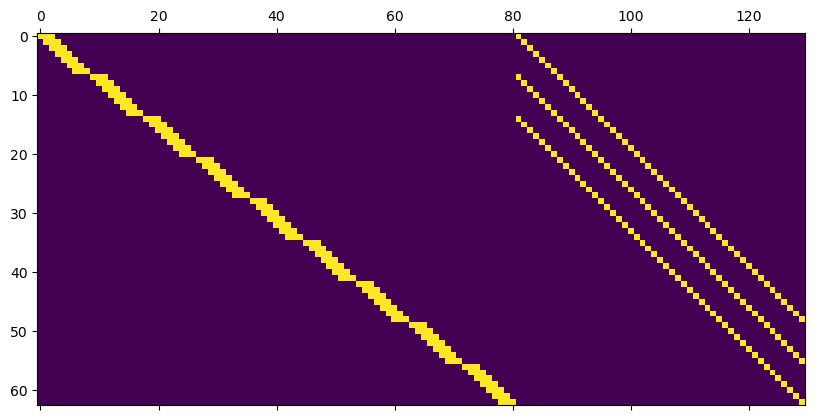

In [23]:
hgp_qcode = read_qcode("../codes/qcodes/lacross/HGP_130_4/HGP_130_4.qcode")
qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/lacross/HGP_34_4/HGP_C422_68_4.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/expander/HGP_100_4/HGP_100_4.qcode")
# qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C422_800_16.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_900_36.qcode")
# qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C422_1800_36.qcode")



hgp_Hx, hgp_Hz, hgp_Lx, hgp_Lz, _ = hgp_qcode.to_numpy()
Hx, Hz, Lx, Lz, mapping = qcode.to_numpy()

cn = qcode.n
cmx = qcode.xm
cmz = qcode.zm

tot_qbts = cn+cmx+cmz


qubit_error_rate = 0.01
meas_error_rate = 0.01

stab_type = False
tanner = True if meas_error_rate else False

H = Hx if stab_type else Hz
hgp_H = hgp_Hx if stab_type else hgp_Hz

# qed_dec_H = H[:qcode.qedxm]
# qed_channel_probs = [qubit_error_rate]*H.shape[1]

qec_aug_dec_H = np.hstack([hgp_H, np.eye(hgp_H.shape[0], dtype=int)])
qec_aug_channel_probs = [qubit_error_rate]*hgp_H.shape[1] + [meas_error_rate]*(hgp_H.shape[0])

qec_dec_H = hgp_H
qec_channel_probs = [qubit_error_rate]*hgp_H.shape[1]
L = Lx if stab_type else Lz

plt.matshow(qec_dec_H)
# print(np.count_nonzero(Hx, axis=1))

In [24]:
print(qcode.Lx)
print(qcode.Lz)

[[63, 64, 66, 67, 69, 70], [63, 65, 66, 68, 69, 71], [72, 73, 75, 76, 78, 79], [72, 74, 75, 77, 78, 80]]
[[7, 16, 34, 43, 61, 70], [8, 17, 35, 44, 62, 71], [7, 25, 34, 52, 61, 79], [8, 26, 35, 53, 62, 80]]


In [25]:
def find_pivots(N, Lx, Lz):
    # assuming full rank classical codes ...
    k = int(np.sqrt(len(Lx)))
    coeff = [2, -2*k, (k**2-N)]
    m, n = sorted(abs(np.roots(coeff).astype(int)))

    grid = np.arange(n**2).reshape(n,n)
    loc = np.empty(len(Lx), dtype=object)
    for i in range(len(Lx)):
        tmp = np.intersect1d(np.where(Lx[i])[0], np.where(Lz[i])[0])[0]
        loc[i] = (tmp//n, tmp%n)

    return grid, loc
grid, loc = find_pivots(qcode.n, Lx, Lz)
print(grid)
print(loc)

[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]
 [18 19 20 21 22 23 24 25 26]
 [27 28 29 30 31 32 33 34 35]
 [36 37 38 39 40 41 42 43 44]
 [45 46 47 48 49 50 51 52 53]
 [54 55 56 57 58 59 60 61 62]
 [63 64 65 66 67 68 69 70 71]
 [72 73 74 75 76 77 78 79 80]]
[(7, 7) (7, 8) (8, 7) (8, 8)]


In [5]:
pivot_rows = set([ind[0] for ind in loc])
pivot_columns = set([ind[1] for ind in loc])

def Qp(Hx, Hz, cols):
    punctured_cols = pivot_columns - cols
    punctured_qbts = grid[:, list(punctured_cols)].flatten()
    print(punctured_qbts)

    mask = ~np.any(Hx[:, punctured_qbts] == 1, axis=1)
    # punc_Hx = Hx[mask]
    punc_Hx = Hx.copy()
    punc_Hx[~mask] = 0
    punc_Hz = Hz.copy()

    punc_Hx[:, punctured_qbts] = 0
    punc_Hz[:, punctured_qbts] = 0

    return punc_Hx, punc_Hz

def Qpp(Hx, Hz, rows):
    punctured_rows = rows
    punctured_qbts = grid[list(punctured_rows)].flatten()
    print(punctured_qbts)

    mask = ~np.any(Hz[:, punctured_qbts] == 1, axis=1)
    # punc_Hz = Hz[mask]
    punc_Hz = Hz.copy()
    punc_Hz[~mask] = 0
    punc_Hx = Hx.copy()

    punc_Hx[:, punctured_qbts] = 0
    punc_Hz[:, punctured_qbts] = 0

    return punc_Hx, punc_Hz

In [6]:
log_qbts = 0
rows = loc[log_qbts][0]
cols = loc[log_qbts][1]

Qp_Hx, Qp_Hz = Qp(Hx, Hz, {cols})
Qpp_Hx, Qpp_Hz = Qpp(Qp_Hx, Qp_Hz, {rows})

[ 4  9 14 19 24]
[15 16 17 18 19]


In [ ]:
def prepare_code(Hx, Hz, qbts, stab_type):
    c = stim.Circuit()
    data_qbts, x_checks, z_checks = qbts

    if stab_type:
        c.append("H", [qbt for qbt in data_qbts])
        for z in np.arange(qcode.zm):
            gen_qbts = data_qbts[np.where(Hz[z])[0]]
            for qbt in gen_qbts:
                path_qbts = [qbt, z_checks[z]]
                c.append("CNOT", path_qbts)
        for i, z_check in enumerate(np.arange(Hz.shape[0])):
            c.append("MR", z_checks[z_check])
    else:
        c.append("H", x_checks)
        for x in np.arange(qcode.xm):
            gen_qbts = data_qbts[np.where(Hx[x])[0]]
            for qbt in gen_qbts:
                path_qbts = [x_checks[x], qbt]
                c.append("CNOT", path_qbts)
        c.append("H", x_checks)
        for i, x_check in enumerate(np.arange(Hx.shape[0])):
            c.append("MR", x_checks[x_check])

    return c

def get_qubits(cb):
    data_qbts = np.arange((cb*tot_qbts), cn+(cb*tot_qbts))
    x_checks = np.arange((cb*tot_qbts)+cn,(cb*tot_qbts)+(cn+cmx))
    z_checks = np.arange((cb*tot_qbts)+(cn+cmx),(cb*tot_qbts)+(cn+cmx+cmz))
    return (data_qbts, x_checks, z_checks)

def GPPM(log_qbts):
    c = stim.Circuit()

    rows = loc[log_qbts][0]
    cols = loc[log_qbts][1]

    Qp_Hx, Qp_Hz = Qp(Hx, Hz, {cols})
    Qpp_Hx, Qpp_Hz = Qpp(Qp_Hx, Qp_Hz, {rows})

    data_qbts1, _, _ = get_qubits(0)
    data_qbts2, _, _ = get_qubits(1)
    data_qbts3, _, _ = get_qubits(2)

    c += prepare_code(Hx, Hz, get_qubits(0), False)
    c.append("TICK")
    # change logicals
    c.append("X", [15,17,18])
    # c.append("X", [21,22,24])
    c += prepare_code(Qp_Hx, Qp_Hz, get_qubits(1), False)
    c.append("TICK")
    c += prepare_code(Qpp_Hx, Qpp_Hz, get_qubits(2), True)
    c.append("TICK")

    nonzero1 = np.count_nonzero(Hx, axis=0)
    nonzero2 = np.count_nonzero(Qp_Hx, axis=0)
    nonzero3 = np.count_nonzero(Qpp_Hx, axis=0)

    for i in range(Hx.shape[1]):
        if (nonzero3[i] and nonzero2[i]):
            c.append("CNOT", [data_qbts3[i], data_qbts2[i]])
    c.append("MX", data_qbts3)

    for i in range(Hx.shape[1]):
        if (nonzero1[i] and nonzero2[i]):
            c.append("CNOT", [data_qbts1[i], data_qbts2[i]])

    # measure Q' in the Z basis
    c.append("M", data_qbts2)

    return c


def test():
    c = stim.Circuit()

    data_qbts1, _, _ = get_qubits(0)

    c += prepare_code(Hx, Hz, get_qubits(0), False)
    c.append("TICK")
    c.append("X", [15,17,18])
    c.append("M", data_qbts1)

    return c


In [14]:
s = stim.TableauSimulator()

c = GPPM(0)
s.do_circuit(c)

z_observables = np.zeros(qcode.k, dtype=int)
x_observables = np.zeros(qcode.k, dtype=int)

stab_type = False

meas = s.current_measurement_record()
for i, logical in enumerate(Lx if stab_type else Lz):
    incl_qbts = np.where(logical)[0]
    incl_qbts = [j-cn for j in incl_qbts]

    if stab_type:
        x_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)
    else:
        z_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)

print(z_observables)
print(x_observables)

[ 4  9 14 19 24]
[15 16 17 18 19]
[0 0 1 0]
[0 0 0 0]


In [361]:
s = stim.TableauSimulator()

c = test()
s.do_circuit(c)

def compute_logicals(meas):
    H = Hx if stab_type else Hz
    for i in range(H.shape[0]):
        incl_qbts = np.where(H[i])[0]
        incl_qbts = np.array([j-cn for j in incl_qbts])

        # if stab_type:
        #     x_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2
        # else:
        #     z_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2

    x_observables = np.zeros(qcode.k, dtype=int)
    z_observables = np.zeros(qcode.k, dtype=int)

    for i, logical in enumerate(Lx if stab_type else Lz):
        incl_qbts = np.where(logical)[0]
        incl_qbts = [j-cn for j in incl_qbts]

        if stab_type:
            x_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)
        else:
            z_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)

    return z_observables, x_observables

z_observables, x_observables = compute_logicals(s.current_measurement_record())

print(z_observables)
print(x_observables)

[1 0 0 0]
[0 0 0 0]


In [257]:
qbt_meas = meas[-34:]
print(np.array(qbt_meas).astype(int)[18])

0


In [188]:
log_qbts = 0
rows = loc[log_qbts][0]
cols = loc[log_qbts][1]

Qp_Hx, Qp_Hz = Qp(Hx, Hz, {cols})
Qpp_Hx, Qpp_Hz = Qpp(Qp_Hx, Qp_Hz, {rows})

print(np.count_nonzero(Qp_Hz, axis=0))
print(np.count_nonzero(Qp_Hx, axis=0))
print(np.count_nonzero(Qpp_Hz, axis=0))
print(np.count_nonzero(Qpp_Hx, axis=0))

[ 4  9 14 19 24]
[15 16 17 18 19]
[1 2 3 2 0 1 2 3 2 0 1 2 3 2 0 1 2 3 2 0 1 2 3 2 0 3 3 3 3 3 3 3 3 3]
[1 1 1 1 0 2 2 2 2 0 3 3 3 3 0 2 2 2 2 0 1 1 1 1 0 3 3 2 3 3 2 3 3 2]
[1 2 3 2 0 1 2 3 2 0 1 2 3 2 0 0 0 0 0 0 1 2 3 2 0 3 3 3 2 2 2 2 2 2]
[1 1 1 1 0 2 2 2 2 0 3 3 3 3 0 0 0 0 0 0 1 1 1 1 0 3 3 2 3 3 2 3 3 2]


In [202]:
np.where(Lz[0])[0]

array([ 3, 13, 18], dtype=int64)

In [ ]:



z_syndrome_history = np.zeros(shape=(2, cmz), dtype=int)
x_syndrome_history = np.zeros(shape=(2, cmx), dtype=int)
z_observables = np.zeros(qcode.k, dtype=int)
x_observables = np.zeros(qcode.k, dtype=int)

stab_type = True
c = prepare_code(Hx, Hz, get_qubits(1), stab_type)
s = stim.TableauSimulator()

s.do_circuit(c)
if stab_type:
    z_syndrome_history[0] = s.current_measurement_record()
else:
    x_syndrome_history[0] = s.current_measurement_record()


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
s = stim.TableauSimulator()

c = stim.Circuit()
c.append("H", 2)
c.append("CNOT", [2,1,1,0,2,3])
c.append("MXX", [1,3])

s.do_circuit(c)

meas = s.current_measurement_record()
if (meas[0]):
    s.do(stim.PauliString("IIZI"))

c = stim.Circuit()
c.append("M", [0,1,2,3])
s.do_circuit(c)

s.current_measurement_record()[-4:]

[True, True, True, True]

In [374]:
s = stim.TableauSimulator()

data_qbts1, _, _ = get_qubits(0)

c = stim.Circuit()
c += prepare_code(Hx, Hz, get_qubits(0), False)
c.append("X", [16,17,19])

c.append("H", data_qbts1)
c.append("MX", data_qbts1)

s.do_circuit(c)

z_observables, x_observables = compute_logicals(s.current_measurement_record())

print(z_observables)
print(x_observables)

[0 1 0 0]
[0 0 0 0]
